## Regression Example - Well test

In this example, we will work on a simplified simulated data to estimate production rates based on well tests. It is a single-phase (brine) geothermal well with an electrical submersible pump (ESP). The data is sampled every 0.5 minute. <br>
For receiving the datasets, you can contact me: pejman.shoeibiomrani@tno.nl

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Import data

In [44]:
file_name = "example_WT2021.csv"
df_raw = pd.read_csv(file_name)
df_raw.describe()

,Time [min],Pump head [bar],Pump Power [W],Pump speed [rpm],Flow rate [m3/d],WHP [bar],WHT [C]
count,3876.000000,3876.000000,3876.000000,3876.000000,3876.000000,3876.000000,3876.000000
mean,968.750000,25.645207,245888.769079,1773.690756,6330.112843,4.566490,80.573614
std,559.524575,6.126133,90680.543845,506.679051,1301.997141,1.779164,0.390644
min,0.000000,10.079043,53407.641250,693.036004,3449.045082,1.980055,79.505964
25%,484.375000,23.824769,200036.964050,1491.309351,5662.234542,3.965818,80.282381
50%,968.750000,28.950655,307740.413050,2005.175724,7163.289954,4.012066,80.570888
75%,1453.125000,29.805125,311015.710375,2193.603947,7257.426696,5.981124,80.887410
max,1937.500000,31.143258,317557.042800,2221.971278,7446.308811,8.079496,81.305924


In [3]:
# Remove NaN
df_raw.dropna(inplace=True)

## Data visualization and correlation

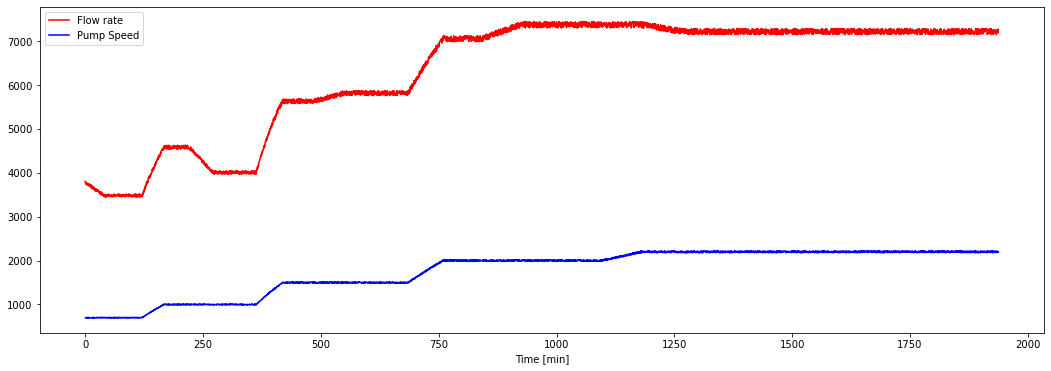

In [16]:
plt.figure(figsize=(18,6))
plt.plot(df_raw['Time [min]'],df_raw['Flow rate [m3/d]'], color='r', label='Flow rate')
plt.plot(df_raw['Time [min]'],df_raw['Pump speed [rpm]'], color='b', label='Pump Speed')
plt.xlabel("Time [min]")
plt.legend()
plt.show()

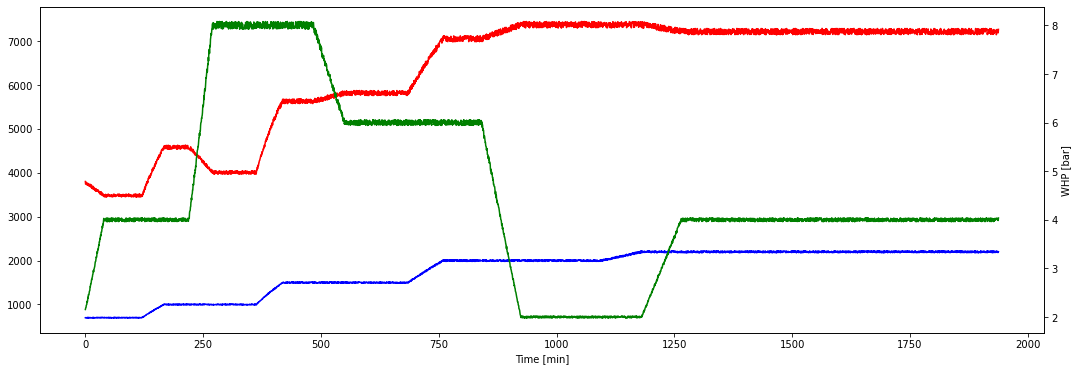

In [15]:
fig,ax = plt.subplots(figsize=[18,6])
ax.plot(df_raw['Time [min]'],df_raw['Flow rate [m3/d]'], color='r', label='Flow rate')
ax.plot(df_raw['Time [min]'],df_raw['Pump speed [rpm]'], color='b', label='Pump Speed')
ax.set_xlabel('Time [min]')

ax2 = ax.twinx()
ax2.plot(df_raw['Time [min]'],df_raw['WHP [bar]'], color='g', label='WHP')
ax2.set_ylabel('WHP [bar]')
plt.show()

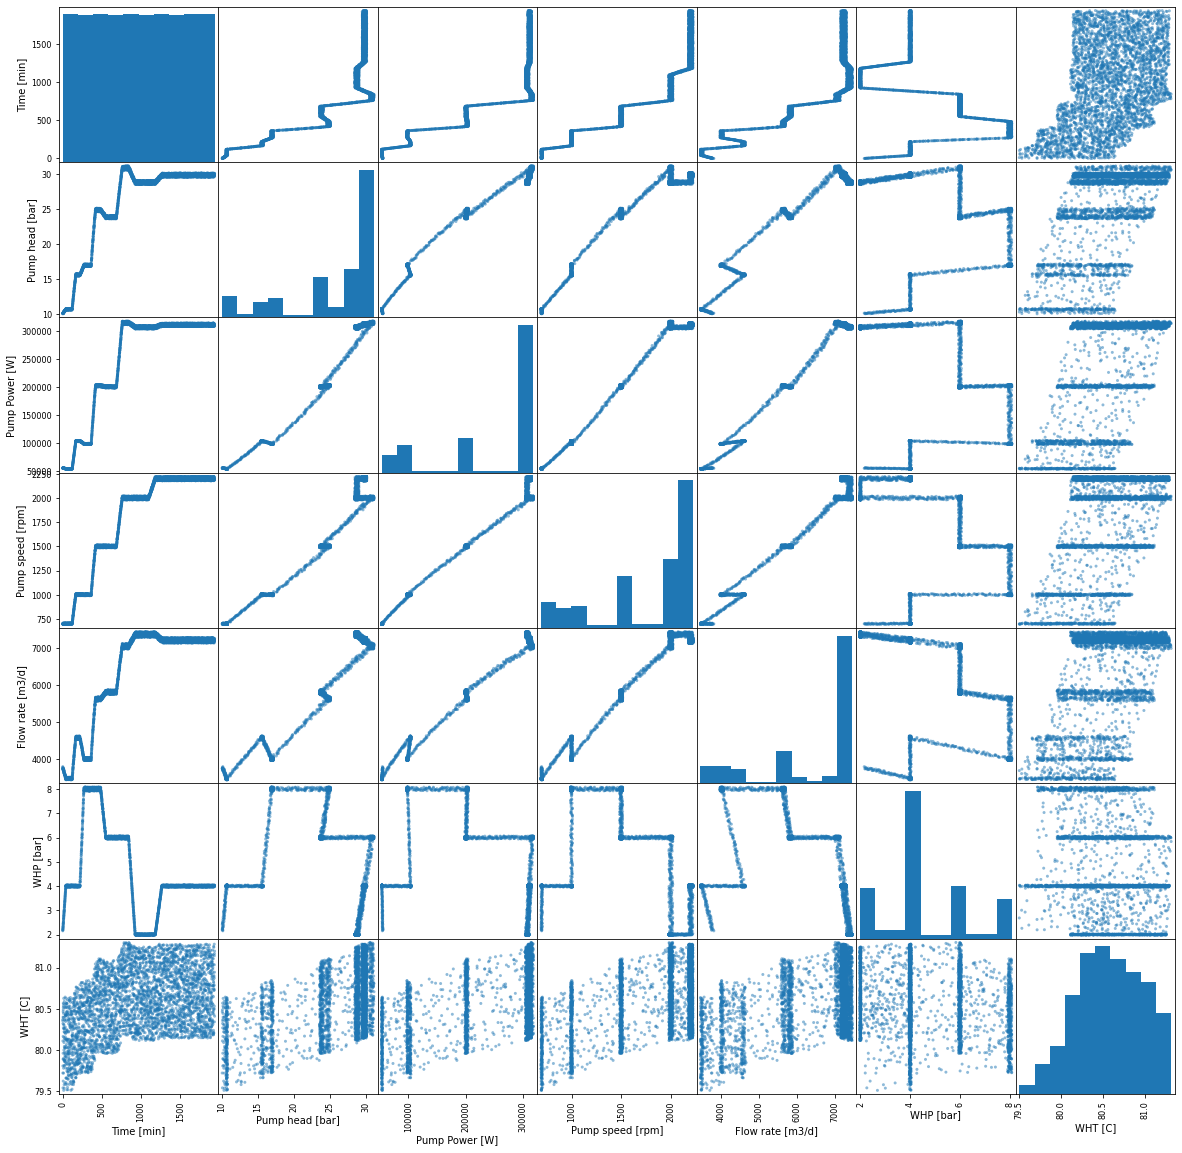

In [17]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_raw, figsize=(20,20));

Text(0, 0.5, 'Flow rate [m3/d]')

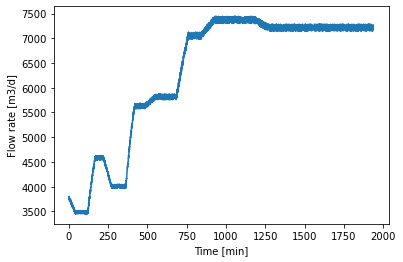

In [18]:
plt.plot(df_raw["Time [min]"], df_raw["Flow rate [m3/d]"]);
plt.xlabel("Time [min]")
plt.ylabel("Flow rate [m3/d]")

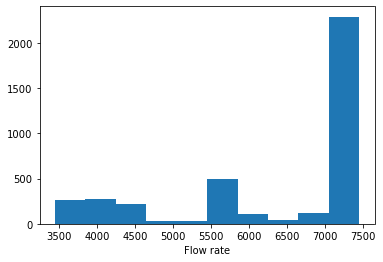

In [19]:
plt.hist(df_raw["Flow rate [m3/d]"])
plt.xlabel("Flow rate");

<AxesSubplot:>

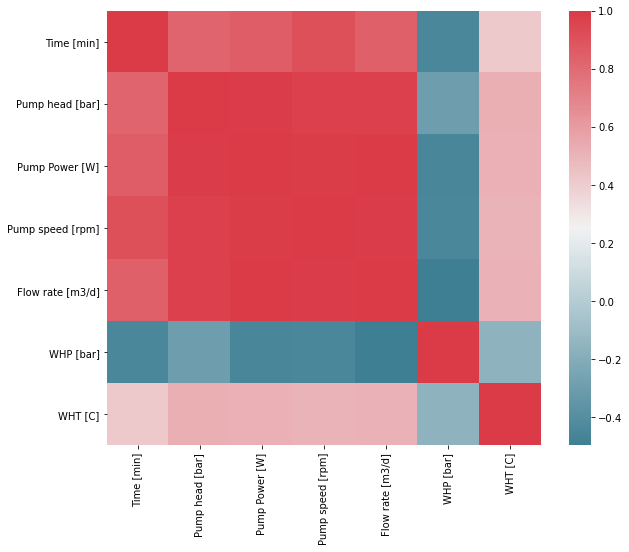

In [20]:
corr = df_raw.corr()
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Training and evaluation

## Steps
Defining the features and predictors. Split the data into training and test sets (in this example the split was done based on random sampling, but it can be done differently). Afterwards a pipeline for the models were built and then the models were trained on the dataset.

In [21]:
df_raw.columns

Index(['Time [min]', 'Pump head [bar]', 'Pump Power [W]', 'Pump speed [rpm]',
       'Flow rate [m3/d]', 'WHP [bar]', 'WHT [C]'],
      dtype='object')

In [22]:
features = [
    'Pump speed [rpm]', 
    'WHP [bar]',
    'WHT [C]'
]

predict = "Flow rate [m3/d]"

In [23]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_raw, test_size=0.1, shuffle=True, random_state=1)

X_train = df_train[features]
X_test = df_test[features]
y_train = df_train[predict]
y_test = df_test[predict]

### Scikit regression models

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [41]:
reg_model = Pipeline([
        ("scalers", MinMaxScaler()),
        ("model", DecisionTreeRegressor()),
    ])

In [42]:
reg_model.fit(X_train, y_train)
rate_pred_train = reg_model.predict(X_train)
rate_pred_test = reg_model.predict(X_test)
reg_model.score(X_test,y_test)

0.9981201641162613

Text(0, 0.5, 'Flow rate [m3/d]')

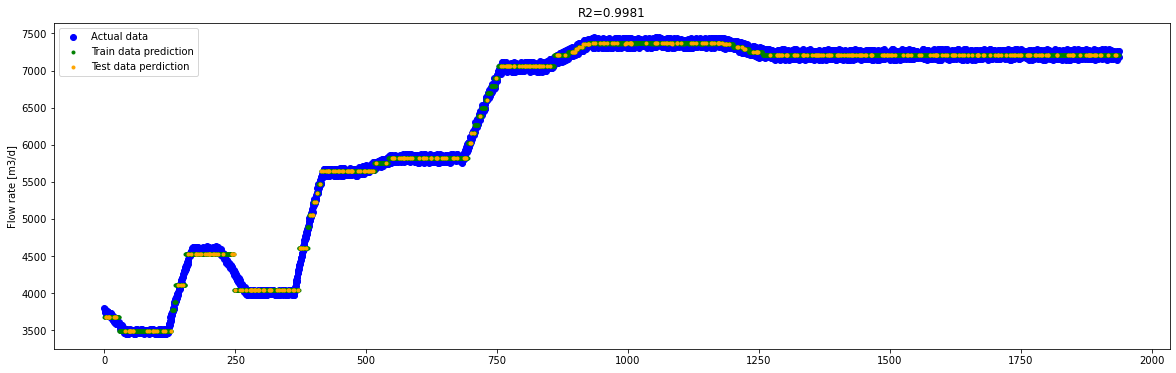

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.scatter(df_raw["Time [min]"], df_raw[predict], color='blue', label="Actual data")
ax.scatter(df_train["Time [min]"], rate_pred_train, marker=".", color='green', label="Train data prediction")
ax.scatter(df_test["Time [min]"], rate_pred_test, marker=".", color='orange', label="Test data perdiction")
ax.set_title("R2={:.4f}".format(reg_model.score(X_test,y_test)))
ax.legend();
ax.set_ylabel(predict)

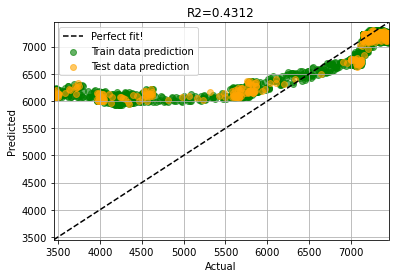

In [30]:
plt.scatter(df_train[predict], reg_model.predict(X_train), marker="o", color="green",alpha=0.6, label="Train data prediction")
plt.scatter(df_test[predict], reg_model.predict(X_test), marker="o", color="orange", alpha=0.6, label="Test data prediction")
lb = min(df_raw[predict])
ub = max(df_raw[predict])
plt.plot([lb, ub], [lb, ub], "k--", label="Perfect fit!")
    
ax = plt.gca()
ax.set_xlim(lb, ub)
ax.set_ylim(lb, ub)
ax.set_title("R2={:.4f}".format(reg_model.score(X_test,y_test)))
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid()
plt.legend()

### Cross Validation

In [31]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(reg_model,X_train,y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.32 accuracy with a standard deviation of 0.02
